Calculating the gain using the peaks extracted from just the Polya model fitted to the integral histograms.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [10]:
#load the csvs with the peak information

spe_df = pd.read_csv('PMT5_spe_COMBINED_polya_peak_positions.csv')
darkrate_df = pd.read_csv('PMT5_darkrate_COMBINED_polya_peak_positions.csv')

#discard non-physical events
spe_df = spe_df[spe_df['polya_peak_pC'] > 0].reset_index(drop=True)
darkrate_df = darkrate_df[darkrate_df['polya_peak_pC'] > 0].reset_index(drop=True)

print('SPE')
print(spe_df)
print('DARKRATE')
print(darkrate_df)

SPE
   voltage  polya_peak_pC  polya_peak_error_pC
0     1750       1.820032             0.180930
1     1800       1.504612             0.051306
2     1850       1.829725             0.057108
3     1900       2.367603             0.030827
4     1950       2.640416             0.141106
5     2000       3.763206             0.233119
DARKRATE
   voltage  polya_peak_pC  polya_peak_error_pC
0     1750       1.538476             0.001016
1     1800       1.329063             0.000204
2     1850       1.572980             0.000448
3     1900       1.910050             0.001324
4     1950       2.757251             0.003596
5     2000       3.699041             0.005360


In [11]:
#add gain columns to the data frames

def add_gain_columns(df):
    df=df.copy()
    df['gain'] = (df['polya_peak_pC']*(1e-12)/(1.6e-19))
    df['gain_error'] = (df['polya_peak_error_pC']*(1e-12)/(1.6e-19))
    return df

spe_df = add_gain_columns(spe_df)
darkrate_df = add_gain_columns(darkrate_df)

In [12]:
#find mean gain for each voltage in case of multiple trials

def average_gain_per_voltage(df):
    grouped = df.groupby('voltage')
    mean_gain = grouped['gain'].mean()
    mean_gain_err = grouped['gain_error'].apply(lambda errs: np.sqrt(np.sum(errs**2)) / len(errs)
    )
    
    out = pd.DataFrame({'voltage': mean_gain.index,
        'gain': mean_gain.values,
        'gain_error': mean_gain_err.values})
    
    return out.sort_values('voltage')

spe_avg_gain = average_gain_per_voltage(spe_df)
print(spe_avg_gain)
darkrate_avg_gain = average_gain_per_voltage(darkrate_df)
print(darkrate_avg_gain)

   voltage          gain    gain_error
0     1750  1.137520e+07  1.130815e+06
1     1800  9.403828e+06  3.206647e+05
2     1850  1.143578e+07  3.569276e+05
3     1900  1.479752e+07  1.926663e+05
4     1950  1.650260e+07  8.819120e+05
5     2000  2.352004e+07  1.456991e+06
   voltage          gain    gain_error
0     1750  9.615474e+06   6350.401285
1     1800  8.306645e+06   1275.531400
2     1850  9.831128e+06   2799.461579
3     1900  1.193781e+07   8276.712552
4     1950  1.723282e+07  22476.205406
5     2000  2.311901e+07  33498.834694


In [13]:
#gain model and fitting
def gain_model(V, A, B):
    return A * V**(14 * B)

def fit_gain_curve(voltage, gain, gain_err):
    p0 = [1e-29, 0.7] #initial guesses
    '''
    bounds = (
        [1e-30, 0.6],   # lower bounds: A, B
        [1e-25, 0.9]    # upper bounds: A, B
    )
    popt, pcov = curve_fit(
        gain_model,
        voltage,
        gain,
        sigma=gain_err,
        absolute_sigma=True,
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )
    '''
    popt, pcov = curve_fit(
        gain_model,
        voltage,
        gain,
        sigma=gain_err,
        absolute_sigma=True,
        p0=p0,
        maxfev=10000
    )

    A_fit, B_fit = popt
    err_A, err_B = np.sqrt(np.diag(pcov))

    return A_fit, B_fit, err_A, err_B


A_spe, B_spe, errA_spe, errB_spe = fit_gain_curve(
    spe_avg_gain['voltage'].values,
    spe_avg_gain['gain'].values,
    spe_avg_gain['gain_error'].values
)

A_dark, B_dark, errA_dark, errB_dark = fit_gain_curve(
    darkrate_avg_gain['voltage'].values,
    darkrate_avg_gain['gain'].values,
    darkrate_avg_gain['gain_error'].values,
)


V_plot = np.linspace(
    min(spe_avg_gain['voltage'].min(), darkrate_avg_gain['voltage'].min()),max(spe_avg_gain['voltage'].max(), darkrate_avg_gain['voltage'].max()),300)


/var/folders/54/shy8r4g15d33hf9px0m5hytc0000gn/T/ipykernel_38074/2851031216.py:3: RuntimeWarning: overflow encountered in power
  return A * V**(14 * B)


In [14]:
#compute chi squareds

def chi_squared(y_data, y_model, y_err, n_params):
    chi2 = np.sum(((y_data-y_model)/y_err)**2)
    dof = len(y_data)-n_params
    chi2_reduced = chi2/dof
    return chi2, chi2_reduced


y_spe_model = gain_model(spe_avg_gain['voltage'].values, A_spe, B_spe)
chi2_spe, chi2_red_spe = chi_squared(
    spe_avg_gain['gain'].values,
    y_spe_model,
    spe_avg_gain['gain_error'].values,
    n_params=2
)


y_dark_model = gain_model(darkrate_avg_gain['voltage'].values,A_dark,B_dark)
chi2_dark, chi2_red_dark = chi_squared(
    darkrate_avg_gain['gain'].values,
    y_dark_model,
    darkrate_avg_gain['gain_error'].values,
    n_params=2
)

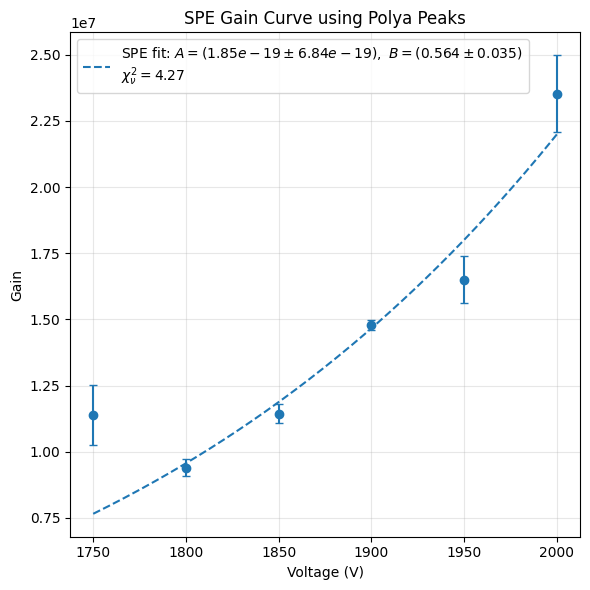

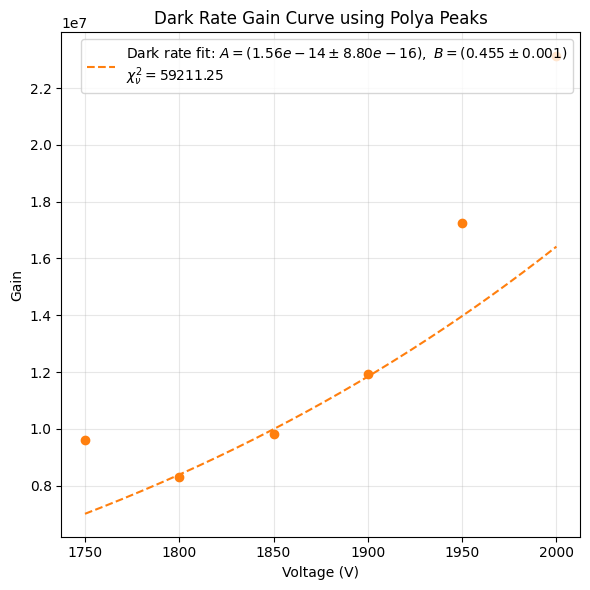

In [15]:
#plot gain curves and gain model = A V^14B separately
plt.figure(figsize=(6, 6))
plt.errorbar(spe_avg_gain['voltage'],spe_avg_gain['gain'],yerr=spe_avg_gain['gain_error'],fmt='o',color='tab:blue',capsize=3)
plt.plot(V_plot,gain_model(V_plot, A_spe, B_spe),'--',color='tab:blue',label=(
        rf'SPE fit: $A=({A_spe:.2e}\pm{errA_spe:.2e}),\ B=({B_spe:.3f}\pm{errB_spe:.3f})$'
        + f'\n$\\chi^2_\\nu={chi2_red_spe:.2f}$'
    ))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.title('SPE Gain Curve using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()


plt.figure(figsize=(6, 6))
plt.errorbar(darkrate_avg_gain['voltage'],darkrate_avg_gain['gain'],yerr=darkrate_avg_gain['gain_error'],fmt='o',color='tab:orange', capsize=3)
plt.plot(V_plot,gain_model(V_plot, A_dark, B_dark),'--',color='tab:orange',label=(
        rf'Dark rate fit: $A=({A_dark:.2e}\pm{errA_dark:.2e}),\ B=({B_dark:.3f}\pm{errB_dark:.3f})$'
        + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
    ))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.title('Dark Rate Gain Curve using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()


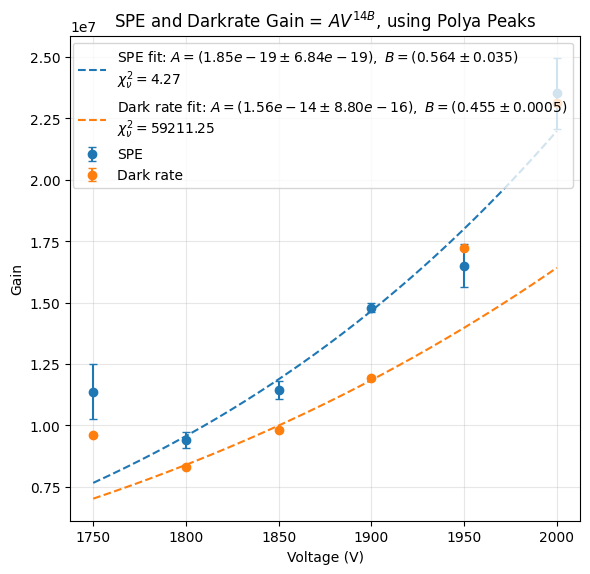

In [16]:
#plot gain curves and gain models = A V^14B together

plt.figure(figsize=(6, 6))
plt.errorbar(spe_avg_gain['voltage'],spe_avg_gain['gain'],yerr=spe_avg_gain['gain_error'],fmt='o',color='tab:blue',capsize=3,label='SPE')
plt.plot(V_plot,gain_model(V_plot, A_spe, B_spe),'--',color='tab:blue',label=(
    rf'SPE fit: '
    rf'$A = ({A_spe:.2e} \pm {errA_spe:.2e}),\ '
    rf'B = ({B_spe:.3f} \pm {errB_spe:.3f})$'
    + f'\n$\\chi^2_\\nu={chi2_red_spe:.2f}$'
))
plt.errorbar(darkrate_avg_gain['voltage'],darkrate_avg_gain['gain'],yerr=darkrate_avg_gain['gain_error'],fmt='o',color='tab:orange',capsize=3,label='Dark rate')
plt.plot(V_plot,gain_model(V_plot, A_dark, B_dark),'--',color='tab:orange',label=(
    rf'Dark rate fit: '
    rf'$A = ({A_dark:.2e} \pm {errA_dark:.2e}),\ '
    rf'B = ({B_dark:.3f} \pm {errB_dark:.4f})$'
    + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.legend()
plt.title(r'SPE and Darkrate Gain = $A V^{14B}$, using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
